- Labels in this dataset:

    - Hardhat
    - NO-Hardhat
    - Safety Vest
    - NO-Safety Vest
    - Gloves
    - No-Gloves
    - Person

- Number of classes: 7
- Label Annotation: YOLO format (.txt):
              `[class_id, center_x, center_y, width, height]`



Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [49]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

In [50]:
! wandb disabled

W&B disabled.


In [51]:
class CFG:
    # classes
    CLASSES = ['Hardhat','NO-Hardhat','Safety Vest','NO-Safety Vest' ,'Gloves', 'No-Gloves', 'Person',]
    NUM_CLASSES_TO_TRAIN = len(CLASSES)  
    FOLDERS = ['train', 'val', 'test']
    # paths
    CUSTOM_DATASET_DIR1 = '/kaggle/input/ppe-detection-cs406/dataset'
    OUTPUT_DIR = './'

# Dataset

- Check some images
- Image utils

## Visualize one image

In [52]:
def display_image(image):
    img = Image.open(image)
    plt.imshow(img)
    
    print('Type: ', type(img), '\n')
    print('Shape: ', np.array(img).shape, '\n')

    plt.axis('off')
    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



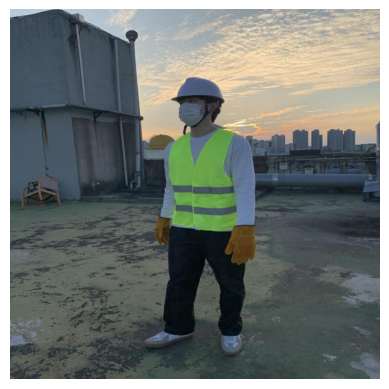

In [53]:
example_image_path = '/kaggle/input/sample/KakaoTalk_20221018_001425789_06_jpg.rf.08732a99429c155352a8e590603460f5.jpg'
display_image(example_image_path)

## Visualize many images

In [54]:
def plot_random_images_from_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    num_cols = 4
    num_rows = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(image_files):
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

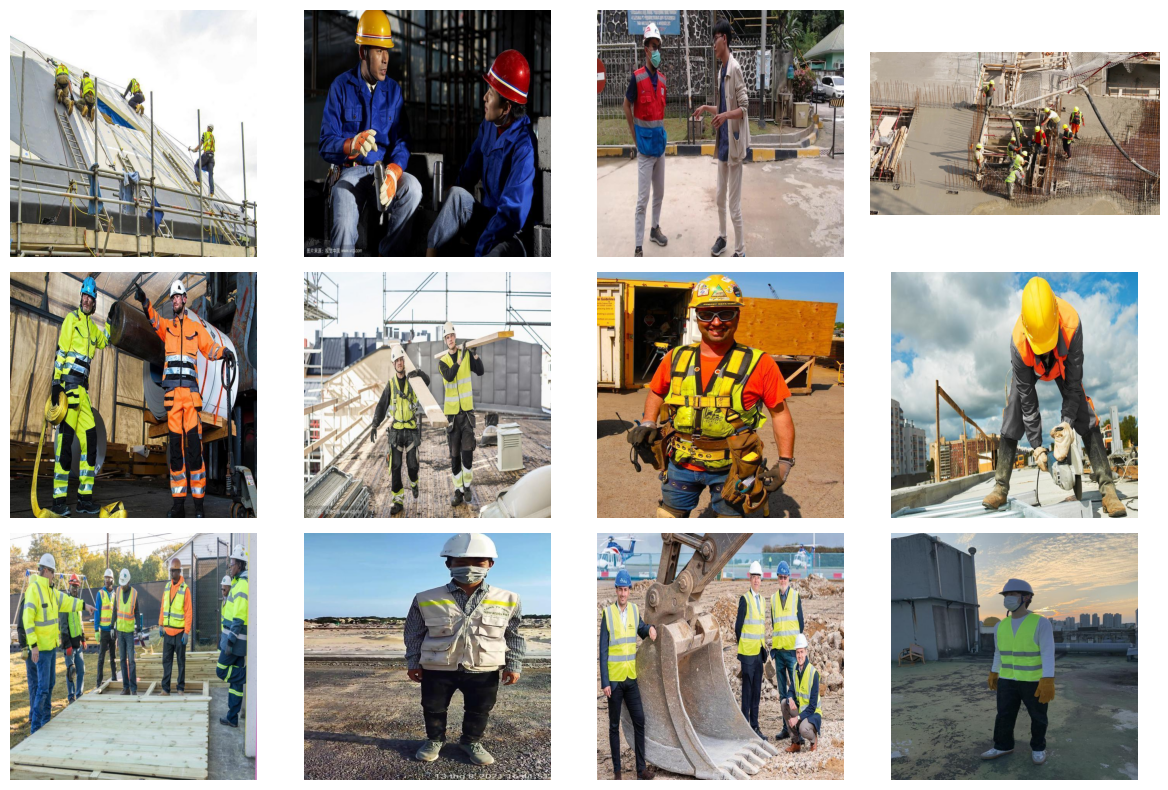

In [55]:
folder_path = '/kaggle/input/sample'
plot_random_images_from_folder(folder_path)

## Image properties

In [56]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [57]:
example_image_path = ''
img_properties = get_image_properties('/kaggle/input/sample/TNPDu_78_jpg.rf.965ed97aecbbf5041e943cc1e2338189.jpg')
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [58]:
import os
import pandas as pd

class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

def calculate_statistics(dataset_dir):
    class_info = []

    for mode in CFG.FOLDERS:
        class_count = {cls: 0 for cls in CFG.CLASSES}
        path = os.path.join(dataset_dir, mode, 'labels')

        if not os.path.exists(path):
            print(f"Path {path} does not exist. Skipping...")
            continue

        for file in os.listdir(path):
            with open(os.path.join(path, file)) as f:
                lines = f.readlines()

                for line in lines:
                    cls = line.split()[0]  # Extract the class ID
                    if cls in class_idx:  # Validate the class ID
                        class_count[class_idx[cls]] += 1

        class_info.append({
            'Mode': mode,
            **class_count,
            'Data_Volume': len(os.listdir(path))
        })

    return pd.DataFrame(class_info)

# Combine statistics from both directories
stats_dir1 = calculate_statistics(CFG.CUSTOM_DATASET_DIR1)

combined_stats = pd.concat([stats_dir1], ignore_index=True)

# Define the correct order for modes
mode_order = ['train', 'val', 'test']

# Set the 'Mode' column as a categorical type with the correct order
combined_stats['Mode'] = pd.Categorical(combined_stats['Mode'], categories=mode_order, ordered=True)

# Group and sum values for each mode
final_stats = combined_stats.groupby('Mode', as_index=False).sum()

# Ensure the final table is sorted by the specified mode order
final_stats = final_stats.sort_values('Mode').reset_index(drop=True)

# Display the table
final_stats

,Mode,Hardhat,NO-Hardhat,Safety Vest,NO-Safety Vest,Gloves,No-Gloves,Person,Data_Volume
0,train,5422,994,4650,638,3455,597,4470,4895
1,val,1342,239,1164,142,759,172,1026,1225
2,test,787,120,700,86,488,83,621,681


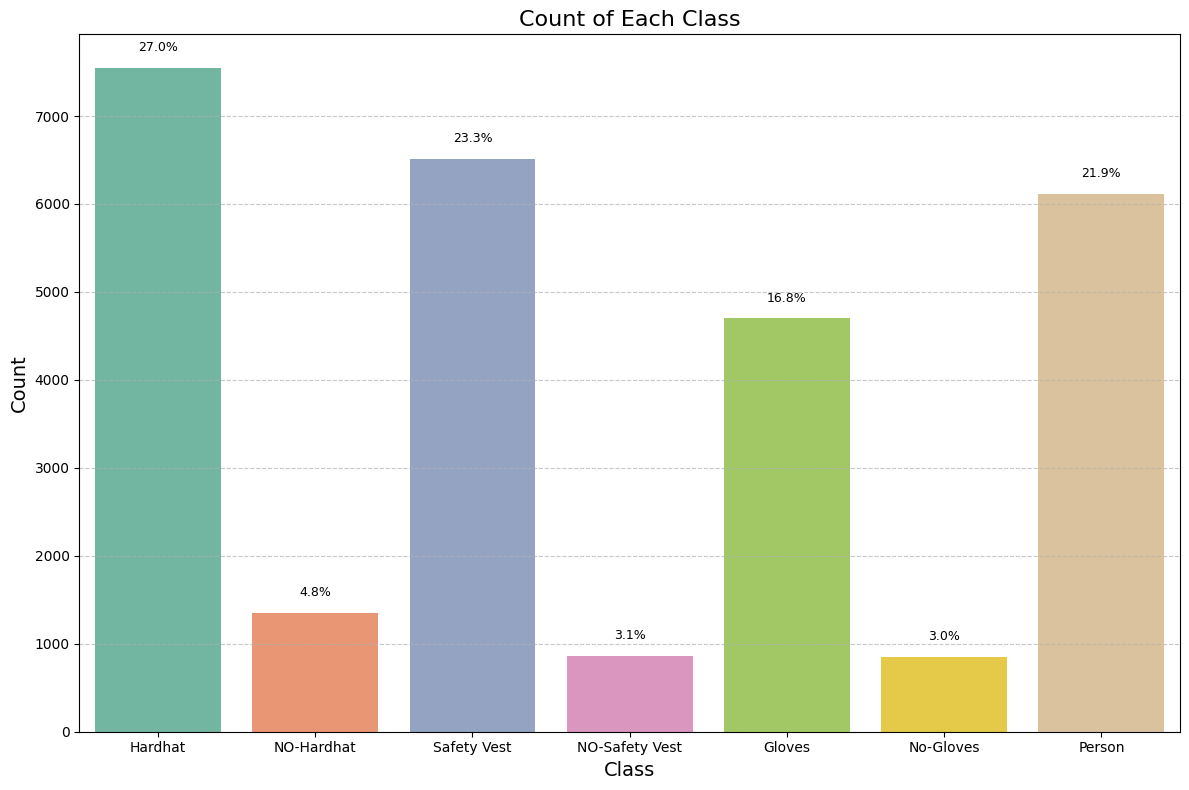

In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_statistics(dataset_dir, classes):
    # Initialize a dictionary to store class counts
    class_data = {cls: 0 for cls in classes}

    # Loop through each folder and parse label files
    for mode in CFG.FOLDERS:
        label_folder = os.path.join(dataset_dir, mode, 'labels')
        if os.path.exists(label_folder):
            for label_file in os.listdir(label_folder):
                if label_file.endswith('.txt'):
                    label_path = os.path.join(label_folder, label_file)
                    with open(label_path, 'r') as f:
                        for line in f:
                            class_id = int(line.split()[0])  # Assuming first column is class ID
                            if class_id < len(classes):
                                class_data[classes[class_id]] += 1

    return pd.DataFrame({'class': list(class_data.keys()), 'count': list(class_data.values())})

# Calculate statistics for the dataset
stats = calculate_statistics(CFG.CUSTOM_DATASET_DIR1, CFG.CLASSES)

# Calculate percentages for visualization
total_count_sum = stats['count'].sum()
stats['percentage'] = (stats['count'] / total_count_sum) * 100

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='class', y='count', data=stats, palette='Set2'
)

# Add percentage annotations
for i, row in stats.iterrows():
    plt.text(
        x=i,
        y=row['count'] + stats['count'].max() * 0.02,
        s=f"{row['percentage']:.1f}%", 
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.title('Count of Each Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


## Image sizes

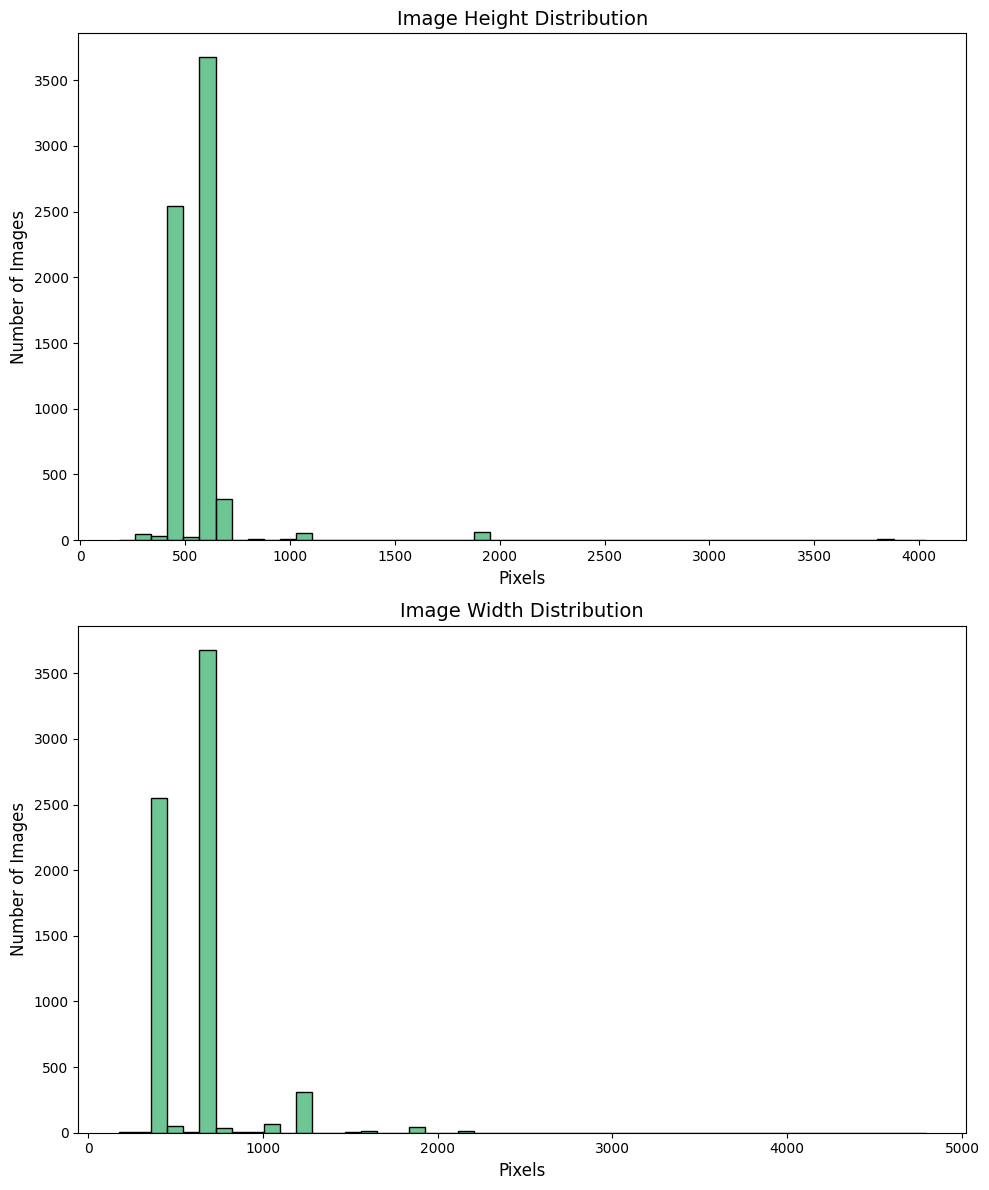

In [60]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Collect image sizes from both directories
image_heights = []
image_widths = []

for dataset_dir in [CFG.CUSTOM_DATASET_DIR1]:
    for mode in CFG.FOLDERS:
        image_folder = os.path.join(dataset_dir, mode, 'images')
        if os.path.exists(image_folder):
            for file in os.listdir(image_folder):
                image_path = os.path.join(image_folder, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    image_widths.append(width)
                    image_heights.append(height)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Height distribution
sns.histplot(image_heights, bins=50, kde=False, color='mediumseagreen', ax=axes[0])
axes[0].set_title('Image Height Distribution', fontsize=14)
axes[0].set_xlabel('Pixels', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)

# Width distribution
sns.histplot(image_widths, bins=50, kde=False, color='mediumseagreen', ax=axes[1])
axes[1].set_title('Image Width Distribution', fontsize=14)
axes[1].set_xlabel('Pixels', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)

plt.tight_layout()
plt.show()


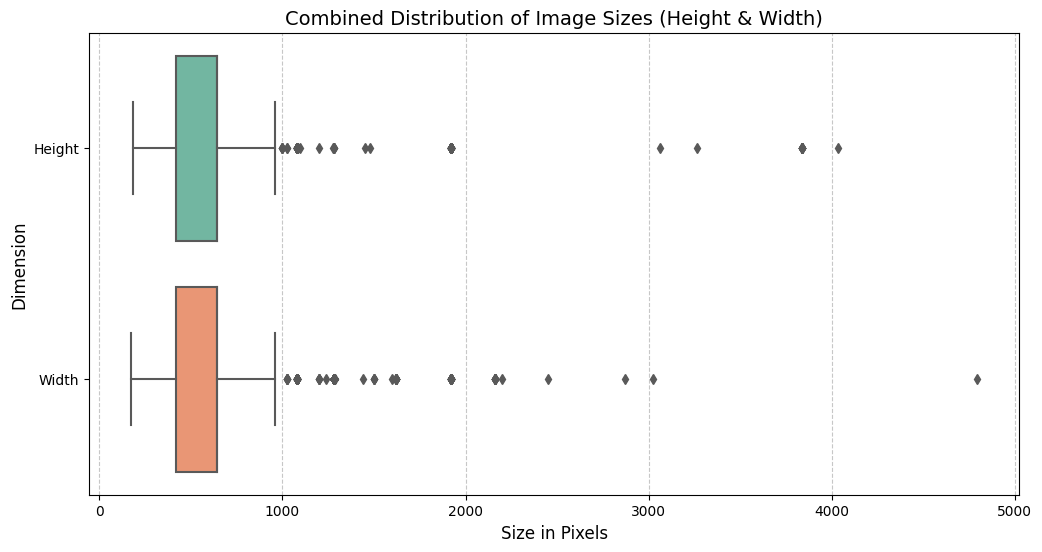

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Initialize an empty dictionary to store image dimensions and sizes
data = {'dimension': [], 'size': []}

# Assuming CFG.FOLDERS, CFG.CUSTOM_DATASET_DIR1, and CFG.CUSTOM_DATASET_DIR2 are already defined
for dataset_dir in [CFG.CUSTOM_DATASET_DIR1]:
    for mode in CFG.FOLDERS:
        image_folder = os.path.join(dataset_dir, mode, 'images')
        if os.path.exists(image_folder):
            for file in os.listdir(image_folder):
                image_path = os.path.join(image_folder, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    # Add the dimension data to the dictionary
                    data['dimension'].extend(['Height', 'Width'])
                    data['size'].extend([height, width])

# Convert the data dictionary into a DataFrame
size_df = pd.DataFrame(data)

# Plotting the box plot with height and width on the y-axis
plt.figure(figsize=(12, 6))
sns.boxplot(x='size', y='dimension', data=size_df, palette='Set2')
plt.title('Combined Distribution of Image Sizes (Height & Width)', fontsize=14)
plt.xlabel('Size in Pixels', fontsize=12)
plt.ylabel('Dimension', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()
